# Download data

In [1]:
# !wget -nc 140.114.76.113:8000/ccpd6000.zip

!wget -nc 140.114.77.221:8000/ccpd6000.zip
!unzip -nq ccpd6000.zip
!ls -alh

File ‘ccpd6000.zip’ already there; not retrieving.

total 318M
drwxr-xr-x 1 root root 4.0K Dec 11 07:52 .
drwxr-xr-x 1 root root 4.0K Dec 11 07:03 ..
drwxr-xr-x 4 root root 4.0K Nov 19 11:35 ccpd6000
-rw-r--r-- 1 root root 317M Nov 19 11:44 ccpd6000.zip
drwxr-xr-x 1 root root 4.0K Dec  6 16:53 .config
drwxr-xr-x 2 root root 4.0K Dec 11 07:51 .ipynb_checkpoints
-rw-r--r-- 1 root root  17K Dec 11 07:48 metrics.png
-rw-r--r-- 1 root root 455K Dec 11 07:51 output.csv
drwxr-xr-x 6 root root 4.0K Dec 11 07:38 runs
drwxr-xr-x 1 root root 4.0K Dec  6 16:53 sample_data


In [2]:
!sha256sum ccpd6000.zip

977d7124a53e565c3f2b371a871ee04ebbe572f07deb0b38c5548ddaae0cb2c9  ccpd6000.zip


## Init and Utility

In [0]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

import skimage
from torchvision import transforms

# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [0]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

## Training Data

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


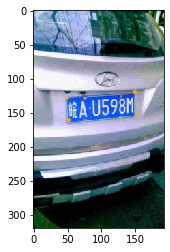

In [5]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)
        # raise NotImplementedError()

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''

        # print(img_path)
        ann = self.anns[idx]
        # print(ann)
        # print(ann['name'])

        img_path = str(self.img_dir) + "/" + str(ann['name'])
        # print(img_path)
        # img = skimage.io.imread(img_path)
        img = Image.open(img_path)
        
        # trans_img = np.array(img, dtype=np.uint8)
        # trans_img = img.astype('float32') / 255.0

        resize_img = img.resize((192, 320), Image.BILINEAR)

        transform1 = transforms.Compose([
            transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
            ]
        )

        tensor_img = transform1(resize_img)

        # trans_img = img / 255.0

        # resize_img = skimage.transform.resize(trans_img, (320, 192, 3)).astype('float32')

        # trans_img = resize_img.astype('float32') / 255.0

        # print(resize_img.shape)

        # resize_img = skimage.transform.resize(trans_img, (320, 192))

        # print(trans_img.shape)
        # aa = trans_img[..., 0]
        # print(aa)
        # H, W, channel = trans_img.shape
        # # print(H)
        # # channel, H, W = trans_img[2], trans_img[1], trans_img[0]
        # img_tensor = torch.zeros(channel, H, W)
        # print(img_tensor.shape)

        # trans_img = np.moveaxis(resize_img, 2, 0)

        # -----------------torch tensor
        # print(trans_img.shape)
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # print(device)
        # tensor_img = torch.tensor(trans_img, device=device).float()
        # tensor_img = torch.from_numpy(trans_img)

        # tensor_img = torch.from_numpy(resize_img)

        # print(tensor_img)

        # ---------------------kpt
        # print("--------------")

        # point = ann[]

        BR_x = ann[FIELDS[0]]/720
        BR_y = ann[FIELDS[1]]/1160
        BL_x = ann[FIELDS[2]]/720
        BL_y = ann[FIELDS[3]]/1160

        TL_x = ann[FIELDS[4]]/720
        TL_y = ann[FIELDS[5]]/1160
        TR_x = ann[FIELDS[6]]/720
        TR_y = ann[FIELDS[7]]/1160

        kpt = torch.tensor([BR_x, BR_y, BL_x, BL_y, TL_x, TL_y, TR_x, TR_y])
        # print(kpt.shape)

        # print(ann[FIELDS[0]])

        return tensor_img, kpt
        # raise NotImplementedError()


# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

# data[-1]

img, kpt = data[-1] # get a sample

print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

## Network

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((4, 4)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
        )
        self.regression = nn.Sequential(
            nn.Flatten(), nn.Linear(480, 32), nn.ReLU(), nn.Linear(32, 8), nn.Sigmoid()
        )

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and 
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        conv_b = self.features(img_b)
        kpt_b = self.regression(conv_b)
        return kpt_b
        # raise NotImplementedError()


# Do some checking
loader = DataLoader(data, batch_size=10) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([10, 3, 320, 192])
torch.Size([10, 8])
tensor(0.1254, device='cuda:0', grad_fn=<L1LossBackward>)


## Training

Epoch 000:
train loss: 0.03325063991360366
valid loss: 0.019498880440369248
Epoch 001:
train loss: 0.017334621562622488
valid loss: 0.016234469398235283
Epoch 002:
train loss: 0.013884017251742382
valid loss: 0.013176055982088049
Epoch 003:
train loss: 0.01295346996630542
valid loss: 0.014072981554393967
Epoch 004:
train loss: 0.011916427878895774
valid loss: 0.010321043408475816
Epoch 005:
train loss: 0.011000770080136136
valid loss: 0.010539159349476298
Epoch 006:
train loss: 0.010375040664803237
valid loss: 0.012468009457613031
Epoch 007:
train loss: 0.010372634189358602
valid loss: 0.01092843923252076
Epoch 008:
train loss: 0.009437509913307924
valid loss: 0.01023198403418064
Epoch 009:
train loss: 0.00968689231085591
valid loss: 0.01035125613367806
Epoch 010:
train loss: 0.009833368323355293
valid loss: 0.010023444999630253
Epoch 011:
train loss: 0.009074104763567448
valid loss: 0.0097497025039047
Epoch 012:
train loss: 0.008840172836789862
valid loss: 0.009468874661251903
Epoch 0

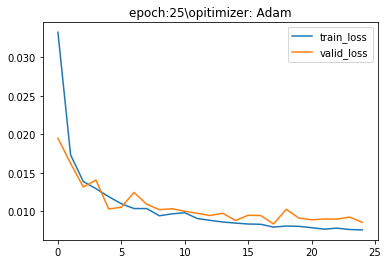

In [8]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, 10, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 10, shuffle=False, num_workers=4)
        self.visul_loader = DataLoader(self.visul_set, 10, shuffle=False)

        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = Net().to(self.device)
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        # self.optimizer = torch.optim.Adagrad(self.model.parameters(), lr=1e-3, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
        # self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=1e-3, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
        self.max_epoch = 25

    def run(self):
        metrics = {'train_loss': [], 'valid_loss': []}

        for self.epoch in range(self.max_epoch): # 5 epochs
            train_loss = self.train() # train 1 epoch
            valid_loss = self.valid() # valid 1 epoch
            self.visul()              # visualization

            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)

        # Save the parameters(weights) of the model to disk
        # Print model's state_dict
        # print("Model's state_dict:")
        # for param_tensor in model.state_dict():
        #     print(param_tensor, "\t", self.model.state_dict()[param_tensor].size())

        self.chkpt_dir = Path('./runs/model.pkl')
        torch.save(self.model.state_dict(), self.chkpt_dir)
        # raise NotImplementedError()

        # Plot the loss curve against epoch
        plt.title("epoch:"+str(self.max_epoch)+"\opitimizer: Adam")
        plt.plot(metrics['train_loss'], label="train_loss")
        plt.plot(metrics['valid_loss'], label="valid_loss")
        plt.legend()

        # save_ckpt_dir = str(self.log_dir) + "/metrics.png"
        # save_ckpt_dir = self.log_dir / 'metrics.png'
        # plt.savefig(self.save_ckpt_dir, bbox_inches='tight')
        plt.savefig('metrics.png')
        plt.show()
        # plt.savefig('metrics.png')
        # raise NotImplementedError()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''

        his_loss = []
        average_loss = 0.0

        self.model.train()

        idx = 0
        for img_b, kpt_b in iter(self.train_loader):

            img_b = img_b.to(device)
            kpt_b = kpt_b.to(device)

            self.optimizer.zero_grad()
            ps = self.model(img_b)
            loss = self.criterion(ps, kpt_b)
            loss.backward()
            self.optimizer.step()

            his_loss.append(loss.detach().item())
        
        # print(history_loss)
        average_loss = sum(his_loss)/len(his_loss)

        return average_loss
        # raise NotImplementedError()

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''

        his_valLoss = []
        average_valLoss = 0.0

        self.model.eval()
        idx = 0
        for img_b, kpt_b in iter(self.valid_loader):

            img_b = img_b.to(device)
            kpt_b = kpt_b.to(device)
            ps = self.model(img_b)
            val_loss = self.criterion(ps, kpt_b)

            his_valLoss.append(val_loss.detach().item())

        average_valLoss = sum(his_valLoss)/len(his_valLoss)


        return average_valLoss

        # raise NotImplementedError()

    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='red')
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
Trainer(log_dir).run()

## Testing

In [0]:
# # Do testing

class TestData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)
        # raise NotImplementedError()

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''

        ann = self.anns[idx]

        img_path = str(self.img_dir) + "/" + str(ann['name'])

        img = Image.open(img_path)
        resize_img = img.resize((192, 320), Image.BILINEAR )
        transform1 = transforms.Compose([
            transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
            ]
        )
        tensor_img = transform1(resize_img)

        # img = skimage.io.imread(img_path)

        # trans_img = img.astype('float32') / 255.0
        # resize_img = skimage.transform.resize(trans_img, (320, 192, 3)).astype('float32')

        # trans_img = np.moveaxis(resize_img, 2, 0)

        # tensor_img = torch.from_numpy(trans_img)

        BR_x = ann[FIELDS[0]]/720
        BR_y = ann[FIELDS[1]]/1160
        BL_x = ann[FIELDS[2]]/720
        BL_y = ann[FIELDS[3]]/1160

        TL_x = ann[FIELDS[4]]/720
        TL_y = ann[FIELDS[5]]/1160
        TR_x = ann[FIELDS[6]]/720
        TR_y = ann[FIELDS[7]]/1160

        kpt = torch.tensor([BR_x, BR_y, BL_x, BL_y, TL_x, TL_y, TR_x, TR_y])

        return tensor_img, kpt

# -------------------------------------------------------------------------------------------------

class TestRunner:
    def __init__(self):

        self.test_data = TestData(ROOT_DIR / 'sample.csv', ROOT_DIR / 'test_images')
        # pivot = len(data) * 4 // 5
        # self.test_set = Subset(data, range(0, pivot))
        self.test_loader = DataLoader(self.test_data, 1, shuffle=False, num_workers=4)

        # model, loss function
        self.device = 'cuda'
        self.loadchkpt_dir = Path('./runs/model.pkl')
        self.model = Net().to(self.device)
        # self.model.eval()
        self.model.load_state_dict(torch.load(self.loadchkpt_dir))

    def run(self):

        # self.test()

        point = self.test()
        return point

    def test(self):

        self.model.eval()

        # for img_b, kpt_b in iter(self.test_loader):
        #     device = 'cuda' 
        #     pred_b = self.model(img_b.to(self.device)).to(device)
        #     pred_b = self.model(img_b.to(self.device)).cpu()
        #     for img, kpt, pred in zip(img_b, kpt_b, pred_b):
        #         img_b = img_b.to(device)
        #         # kpt_b = kpt_b.to(device)
        #         ps = self.model(img_b)

        #         # size = torch.tensor([720, 1160]).float()
        #         # recover_kpts = ps.view(4, 2) * size
        #         # recover_kpts = recover_kpts.numpy()

        #         # img = tf.to_pil_image(img)
        #         # vis = draw_kpts(img, kpt, c='orange')
        #         # vis = draw_kpts(img, pred, c='red')
        #         # vis.save(epoch_dir / f'{idx:03d}.jpg')
        #         # print(recover_kpts)

        #         # idx += 1

        # history = {
        #     'loss': []
        # }

        pred_kpt = []
        

        for img_b, kpt_b in iter(self.test_loader):

            img_b = img_b.to(device)
            kpt_b = kpt_b.to(device)
            ps = self.model(img_b)

            # print(ps)

            # size = torch.tensor([720, 1160]).float()
            # recover_kpts = ps.view(4, 2) * size
            # recover_kpts = recover_kpts.numpy()

            # print(size[0])

            # history[]

            pred_kpt += ps.tolist()

        return pred_kpt
        # # return pred_kpt



# ----------------------------------------------------------------------------------------------------------------

data = TestData(ROOT_DIR / 'sample.csv', ROOT_DIR / 'test_images')

# TestRunner().run()
kpt = TestRunner().run()

# print("----------------------")
# print(kpt)

# raise NotImplementedError()

## Write CSV








In [10]:
# # recover keypoint and write predict point to csv file

# size = torch.tensor([720, 1160]).float()
# recover_kpts = kpt.view(4, 2) * size
# recover_kpts = recover_kpts.numpy().tolist()

# print(kpt)

anns = pd.read_csv(ROOT_DIR / 'sample.csv').to_dict('records')

recover_kpt = []
name=['name','BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']

# for i in range(3):

for i in range(len(kpt)):

    ann = anns[i]

    idx = kpt[i]

    BR_x = idx[0]*720
    BR_y = idx[1]*1160
    BL_x = idx[2]*720
    BL_y = idx[3]*1160

    TL_x = idx[4]*720
    TL_y = idx[5]*1160
    TR_x = idx[6]*720
    TR_y = idx[7]*1160

    temp_kpt = [ann['name'], BR_x, BR_y, BL_x, BL_y, TL_x, TL_y, TR_x, TR_y]

    # recover_kpt += temp_kpt
    recover_kpt.append(temp_kpt)

    # # kpt = np.array([BR_x, BR_y, BL_x, BL_y, TL_x, TL_y, TR_x, TR_y])
    # print(TR_y)
    # print(idx)
    # print("-----------")
    # print(idx[0]*720.0)

# print(recover_kpt.reshape(3, 8))

write_data = pd.DataFrame(columns=name, data=recover_kpt)
print(write_data)
write_data.to_csv('output2.csv',encoding='gbk', index=False)

          name        BR_x        BR_y  ...        TL_y        TR_x        TR_y
0     0000.jpg  376.741490  601.926394  ...  509.874004  371.558647  550.662341
1     0001.jpg  437.300749  528.455752  ...  477.818847  437.841525  476.700554
2     0002.jpg  461.465220  505.393054  ...  471.079739  460.586100  470.236906
3     0003.jpg  506.111641  592.434111  ...  518.062972  502.665238  533.397011
4     0004.jpg  440.579224  582.429283  ...  524.065723  436.496859  511.709224
...        ...         ...         ...  ...         ...         ...         ...
2995  2995.jpg  444.229989  634.482031  ...  575.318506  443.140883  586.738381
2996  2996.jpg  500.958967  627.508292  ...  568.911173  499.525509  573.909128
2997  2997.jpg  318.426962  375.857252  ...  322.592282  317.571208  331.160940
2998  2998.jpg  446.877179  554.637418  ...  469.839066  439.046373  482.535188
2999  2999.jpg  506.446853  650.664434  ...  529.088811  498.792086  585.823987

[3000 rows x 9 columns]


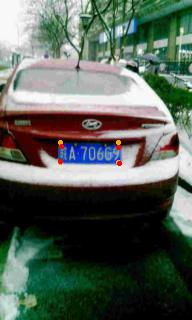

In [11]:
display.Image(str(log_dir / '004' / '000.jpg')) # A visualization of training data in epoch 4

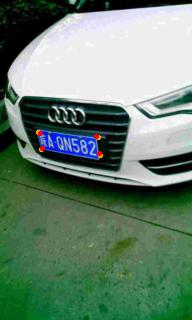

In [14]:
display.Image(str(log_dir / '015' / '025.jpg')) # A visualization of validation data in epoch 4

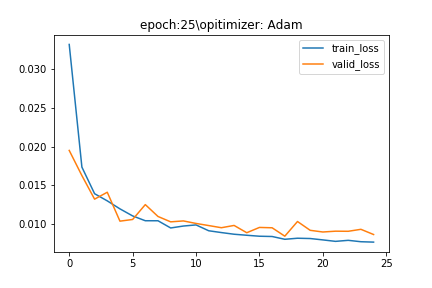

In [15]:
display.Image('./metrics.png') # Loss

In [13]:
!curl -F "file=@./output2.csv" -X POST 140.114.76.113:5000/cs6550 -i

HTTP/1.1 100 Continue

HTTP/1.0 200 OK
Content-Type: application/json
Content-Length: 14
Server: Werkzeug/0.16.0 Python/3.7.5
Date: Wed, 11 Dec 2019 08:21:05 GMT

{"rmse":14.1}
